# VICA Technical Assessment - Task 1

Name of candidate: Chan Choon Kong

## Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load dataset

The dataset is loaded into a pandas DataFrame. The data types of each column of the DataFrame are as follows:

- `insuree#: int`
- `gender: str`
- `is45OrOlder: bool`
- `hasKids: bool`
- `insuredMonths: int`
- `termLifeInsurance: bool`
- `multipleTermLifePolicies: bool`
- `healthInsurance: str`
- `healthRiders: List[int]`
- `premiumFrequency: int`
- `eStatements: bool`
- `monthlyPremium: float`
- `totalPremium: float`
- `renewal: bool`

Simple preprocessing is done to convert the original data into the data types above. Empty values are preserved and will be handled during the data preprocessing phase afterwards.

In [2]:
dataset_dir = os.path.join(os.curdir, 'mol-vica-ds-challenge-dataset', 'insurance_data.csv')

# Define converters
float_to_bool = lambda x: x == '1.0' if x else None
yesno_to_bool = lambda x: (x == 'Yes' or x == 'Y') if x else None
csfloat_to_dec = lambda x: float(x.replace(',', '.')) if x.replace(',', '.').strip() else np.nan
csint_to_lst = lambda x: list(map(lambda y: int(y), x.split(','))) if x.split(',')[0] else []

df = pd.read_csv(dataset_dir, sep=';', converters={
    'is45OrOlder': float_to_bool, 
    'isMarried': yesno_to_bool, 
    'hasKids': yesno_to_bool, 
    'termLifeInsurance': yesno_to_bool, 
    'multipleTermLifePolicies': yesno_to_bool,
    'eStatements': yesno_to_bool,
    'renewal': yesno_to_bool,
    'healthRiders': csint_to_lst
})

# Note: Int64 writes <NA> for empty integer fields
df['premiumFrequency'] = df['premiumFrequency'].astype('Int64')
df['monthlyPremium'] = df['monthlyPremium'].apply(csfloat_to_dec)
df['totalPremium'] = df['totalPremium'].apply(csfloat_to_dec)
df.head(5)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,False,True,True,23,True,False,No,[],12,True,19.65,451.55,True
1,2,F,True,False,False,42,True,True,Class A,[3],1,True,84.65,3541.35,False
2,3,F,False,True,False,72,True,False,No,[],12,False,19.40,1496.45,True
3,4,F,False,True,True,13,True,False,No,[],12,False,19.55,265.30,True
4,5,F,False,False,False,37,True,True,Class A,"[3, 4]",1,False,100.30,3541.40,True


## Data Processing

### Validity of Data

I will check if there are any rows with invalid data. In this task, I assume that the following criteria implies that the data is invalid.
- Insuree who has multiple term life policies but not a term life policy
- Insuree who does not have term life insurance or health insurance
- Insuree who does not have health insurance but has riders
- Insuree whose total premium is less than their monthly premium

In [3]:
invalid_df = df.loc[(df['multipleTermLifePolicies'] == True) & (df['termLifeInsurance'] == False)]
invalid_df = pd.concat([invalid_df, df.loc[(df['termLifeInsurance'] == False) & (df['healthInsurance'] == 'No')]])
invalid_df = pd.concat([invalid_df, df.loc[(df['healthInsurance'] == False) & (df['healthRiders'].astype(bool) == True)]])
invalid_df = pd.concat([invalid_df, df.loc[df['totalPremium'] < df['monthlyPremium']]])
if invalid_df.shape[0] != 0:
    print("Found {0} invalid row: ".format(invalid_df.shape[0]))
else:
    print("Data is valid")
invalid_df

Found 1 invalid row: 


,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
2115,2116,M,True,False,False,38,True,True,Class A,"[3, 4]",1,False,9475.0,3653.0,True


Based on the criteria above, I found 1 invalid row where the total premium exceeds the monthly premium. Therefore this row will be removed from the dataset.

In [4]:
to_drop = invalid_df.index.values.tolist()
df = df.drop(to_drop)

### Outlier Detection

I will first identify the outliers present in the numeric features of the dataset. Outliers are defined as points which lie outside 1.5 times the interquartile range, i.e. outside [(Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR)], where Q1 and Q3 are the first and third quartiles respectively and IQR is the interquartile range.

<AxesSubplot:>

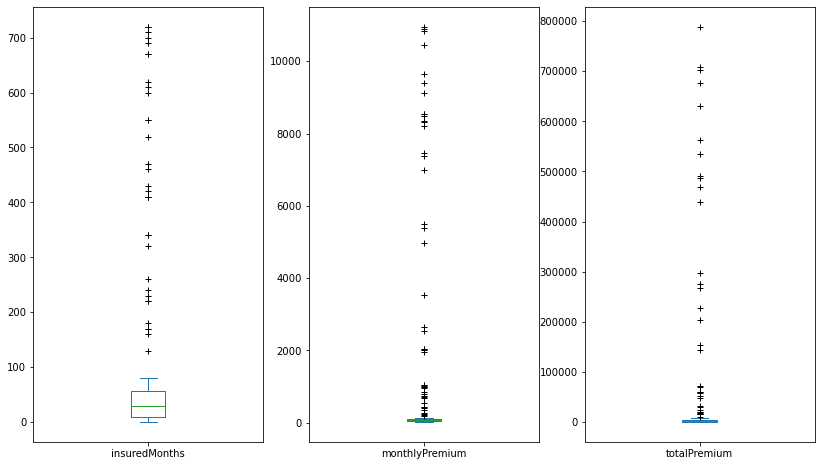

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14,8))
df['insuredMonths'].plot(kind='box', notch=False, sym='+', vert=True, whis=1.5, ax=axes[0])
df['monthlyPremium'].plot(kind='box', notch=False, sym='+', vert=True, whis=1.5, ax=axes[1])
df['totalPremium'].plot(kind='box', notch=False, sym='+', vert=True, whis=1.5, ax=axes[2])

As we can see, there are plenty of outliers especially for `monthlyPremium` and `totalPremium`. We can also find out the total number of outliers for each feature.

In [6]:
sub_df = df[['insuredMonths', 'monthlyPremium', 'totalPremium']]
Q1 = sub_df.quantile(0.25)
Q3 = sub_df.quantile(0.75)
IQR = Q3 - Q1
outlier_df = ((sub_df < (Q1 - 1.5 * IQR)) | (sub_df > (Q3 + 1.5 * IQR)))
print("Number of rows with at least 1 outlier: {0}".format(outlier_df.any(1).sum()))
print("Total number of outliers for each feature:")
((sub_df < (Q1 - 1.5 * IQR)) | (sub_df > (Q3 + 1.5 * IQR))).sum()

Number of rows with at least 1 outlier: 79
Total number of outliers for each feature:


insuredMonths     33
monthlyPremium    46
totalPremium      35
dtype: int64

Since there are only 79 rows with at least 1 outlier which makes up a small proportion (1.44%) of the total dataset, they can be removed from the dataset.

In [7]:
to_drop = outlier_df[outlier_df.any(1)].index.tolist()
df = df.drop(to_drop)

### Handle Missing Values

In [8]:
num_bad_rows = df.shape[0] - df.dropna().shape[0]
print("Total number of rows: {0}".format(df.shape[0]))
print("Number of rows with missing inputs: {0} ({1:.2f}%)".format(num_bad_rows, 100*num_bad_rows/df.shape[0]))
print("Columns with missing inputs: {0}".format(df.columns[df.isnull().any()].tolist()))

Total number of rows: 5420
Number of rows with missing inputs: 324 (5.98%)
Columns with missing inputs: ['gender', 'is45OrOlder', 'premiumFrequency', 'totalPremium']


Out of the 4 columns with missing inputs, 3 of them (`gender`, `is45OrOlder` & `premiumFrequency`) are categorical features while the last column (`totalPremium`) is a numeric feature. For the categorical features, I would replace missing values with the most frequent value of that feature. For the numeric feature, I will replace missing values with the mean value of that feature (after accounting for outliers).

In [9]:
# Categorical features
cat_features = ['gender', 'is45OrOlder', 'premiumFrequency']
cat_dic = dict((feature, df[feature].mode().values[0]) for feature in cat_features)
df = df.fillna(cat_dic)

In [10]:
# Numeric features
num_features = ['totalPremium']
num_dic = dict((feature, round(df[feature].mean(), 2)) for feature in num_features)
df = df.fillna(num_dic)

Check that there are no more rows with missing values:

In [11]:
num_bad_rows = df.shape[0] - df.dropna().shape[0]
print("Number of rows with missing inputs: {0} ({1:.2f}%)".format(num_bad_rows, 100*num_bad_rows/df.shape[0]))

Number of rows with missing inputs: 0 (0.00%)
